# 🌊 Trilha 3: Segmentação de Fácies Sísmicas

### HACKATHON AI FOR OIL & GAS

#### Integrantes: **Rock the Net**

**Members:**
* Matheus do Ó
* João Nogueira
* Juan David Nieto
* Hanna Rodrigues

---

# 1. Introdução

## O Desafio

O objetivo desta trilha é **implementar um modelo de aprendizado de máquina para segmentação semântica de fácies sísmicas**.
A partir de um corte sísmico como entrada, o modelo deve gerar um **mapa de segmentação pixel a pixel** que identifica diferentes fácies geológicas.

Fácies sísmicas representam conjuntos de camadas sedimentares que se diferenciam entre si por propriedades como **amplitude**, **frequência** e **continuidade dos refletores**.
A análise dessas fácies permite inferir **litologia**, **ambiente deposicional** e características estruturais do subsuperfície.

---

## Descrição do Conjunto de Dados

### **Origem:**

  * Dados sísmicos públicos do **New Zealand Petroleum & Minerals (NZPM)**
  * Fácies interpretadas fornecidas pela **Chevron U.S.A. Inc. (CC-BY-SA-4.0)**

### **Treino**

* **18.830 cortes sísmicos (224 × 224)** gerados a partir das seções **inline** e **crossline**
* **Formato:** arrays 2D (float32), representando amplitude sísmica
* **Rótulos:** mapas de fácies correspondentes (int32), mesma resolução dos cortes


### **Teste**

* **4.700 cortes sísmicos (224 × 224)**
* **Formato:** arrays float32, sem rótulos
* **Objetivo:** avaliar a capacidade de generalização do modelo

---

## Métricas de Avaliação

As seguintes métricas serão utilizadas para avaliar o desempenho do modelo:

* **Matriz de Confusão (absoluta):** contagem de acertos e erros por classe
* **Matriz de Confusão (normalizada):** desempenho proporcional por classe
* **IoU por classe (Intersection over Union):** métrica principal para segmentação
* **Precisão:** proporção de predições corretas entre os positivos preditos
* **Recall:** capacidade de encontrar corretamente os pixels reais de cada classe
* **F1-Score:** média harmônica entre precisão e recall
* **Support:** número total de pixels reais de cada classe

---

## Objetivo Principal

* **Métrica Primária:** IoU por classe e IoU médio (mIoU)
* **Abordagem:** desenvolver um modelo de segmentação semântica capaz de identificar padrões de fácies sísmicas com robustez, equilíbrio entre classes e boa generalização para o conjunto de teste.

# Importação

In [1]:
from dataset import *
from train_infer import *
from preprocessing import *
from models import *

import os
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [2]:
device = "cuda"
data_path = "./Sismica"
input_data_path = os.path.join(data_path, "train", "Input", "seismic_TRAIN_IMAGE_crops.npy")
output_data_path = os.path.join(data_path, "train", "Output", "seismic_TRAIN_LABEL_crops.npy")
test_data_path = os.path.join(data_path, "test", "Input", "seismic_TEST_IMAGE_crops_S.npy")

# Análise Exploratória de Dados

In [3]:
train_data = SDataset(input_data_path, output_data_path, transform = make_fast_transform(augment=False))

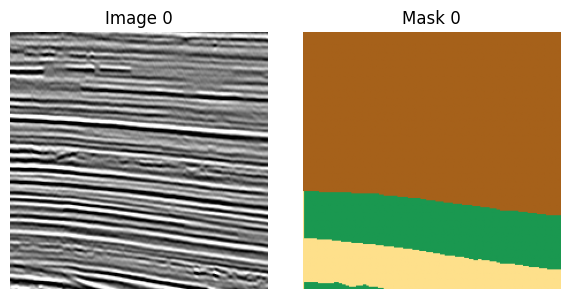

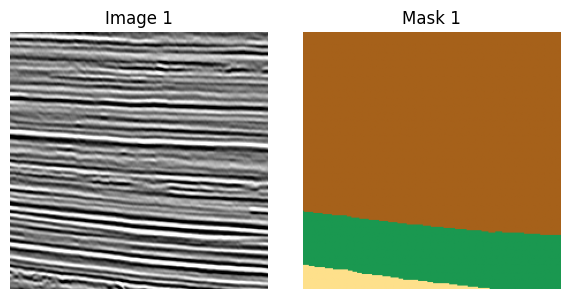

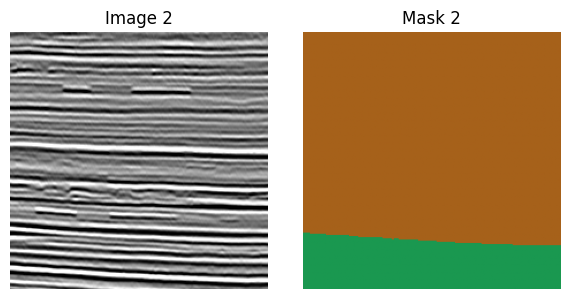

In [4]:
vis_first_samples(train_data,3)

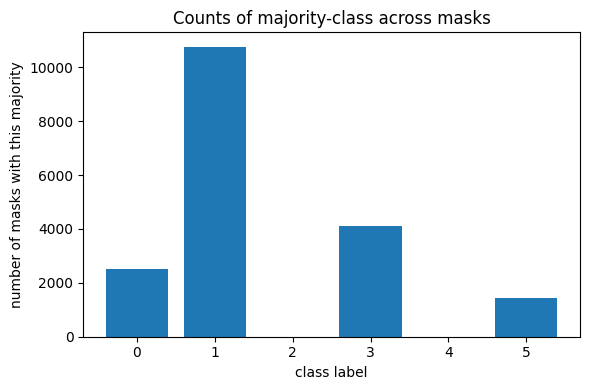

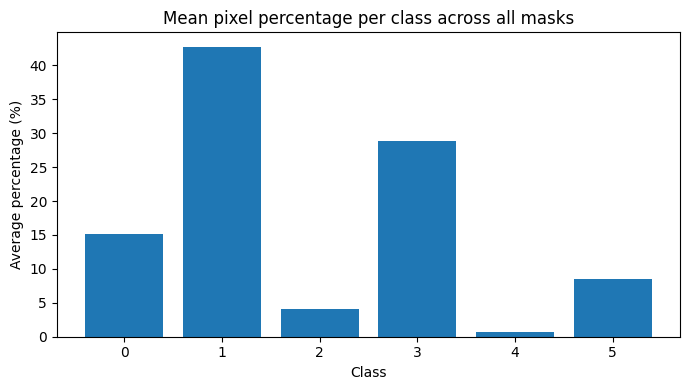

In [5]:
plot_majority_class_counts(train_data.masks)
plot_mean_class_percentage(train_data.masks)

### Desbalanceio forte entre classes

Pelo primeiro gráfico, podemos verificar que as classes $2$ e $4$ quase inexistem, isso afeta diretamente a capacidade de aprendizagem do modelo se não tratado de forma mais esperta. O segundo gráfico indica o percentual médio de cada classe por imagem. Imagine o seguinte: Se sorteio uma imagem aleatória do treino, quantos porcentos, em média, desta imagem pertence à classe $X$? Novamente as classes subrepresentadas possuem o menor percentual.

# Tratamento de dados

## Transformações aplicadas

O preprocessamento pode ser quebrado em três grandes partes:

- Remoção de valores extremos nos pixels através de *Clipping*;
- Transformações geométricas aleatórias, dentre elas, junto de suas respectivas probabilidades, fizemos
  - ***RandomHorizontalFlip***: Essencialmente invertemos a imagem sob o eixo-y com probabilidade $0.5$
  - ***RandomResizedCrop***: Recorta uma parte da imagem e a redimensiona com probabilidade $0.5$
- Transformações mais bruscas como
  - ***ElasticTransform***: Deforma uma imagem, a deixando com aparência de "vista através d'água" com probabilidade $0.3$
  - ***ColorJitter***: Altera o brilho, contrate, saturação e matiz da imagem com probabilidade $0.3$
  - ***GaussianBlur***: Aplica um Gaussian Blur à imagem com probabilidade $0.3$
  - ***RandomErasing***: Seleciona aleatoriamente um retângulo da imagem e apaga seus pixels com probabilidade $0.3$
- Por fim, redimensionamos a imagem quando necessário para o formato $224 \times 224$ e o normalizamos.

## Split em treino e validação

Para o treinamento, separamos $80\%$ do conjunto de treino e reservamos $20\%$ para o conjunto de validação. Para garantir que todas as classes apareçam em ambos os conjuntos e em uma proporção semelhante (simulando a distribuição dos dados), pensamos em um modo único de estratificar. Dado que as duas classes mais raras são a $2$ e $4$, dividimos os dados em $4$ grupos:

- Imagens _sem pixels_ de ambas as classes
- Imagens com pixels da classe $2$, mas _sem_ pixels da classe $4$
- Imagens com pixels da classe $4$, mas _sem_ pixels da classe $2$
- Imagens com pixels da classe $2$ _e_ da classe $4$

Uma abordagem, que infelizmente não tivemos tempo de explorar, era criar um ensemble (conjunto de modelos) que reconhececem estes grupos, separando melhor a dificuldade de identificar classes minoritárias. É algo a se pensar!

In [6]:
train_data, val_data, normalizer = create_stratified_split(input_data_path, output_data_path,
                                   train_size=0.8, random_state=10,
                                   device="cuda")

Generating stratification keys...
Key 0 (no rare): 9185
Key 1 (only 2): 6799
Key 2 (only 4): 2218
Key 3 (both): 628
------------------------------
Constructing normalizer....
Normalizer with mean [np.float32(0.50010794)] and standard devation [np.float32(0.25693664)] constructed
------------------------------
Constructing datasets....
Datasets created
------------------------------


## Dados altamente desbalanceados

# Modelagem

Gostaríamos de uma alternativa sustentável, que possuísse um tempo de computação pequeno e de modo que a acurácia não fosse tão penalizada. Tentamos muitaas alternativas. Dentre elas:

1. UNet de quatro e três camadas, treinadas do zero;
2. Resnet50 pré-treinada + uma camada convolucional;
3. DeepLabv3 com backbone de uma Mobile Net v3 pré-treinada + uma cada convolucional;
4. DeepLabv3 com backbone de uma Mobile Net v3 pré-treinada + UNet do zero

A ideia das redes pré-treinadas é reaproveitar modelos já treinados previamente em tarefas semelhantes a fim de reduzir o tempo e número de épocas necessárias para o nosso treinamento de fine-tuning. A estratégia que mais se alinhou com nosso objetivo foi a 3, na qual tomamos algumas liberdades para aprimorar o resultado final.

## DeepLab v3 - MobileNet v3

A MobileNet é uma arquitetura de rede convolucional desenvolvida pela Google em 2017 e trouxe consigo algumas inovações no modo como executa suas convoluções, com a ideia de _Depth-wise Separable Convolution_, que separa as etapas de filtragem e mistura de canais, no qual camadas convolucionais comuns fazem de uma única vez. Tomar esta novaa abordagem reduz em até $8$-$9\times$ a velocidade de computação e o tamanho do modelo, provendo uma alternativa menor e mais barata para problemas de visão computacional.

Utilizamos um modelo pré-treinado e baseado nesta arquitetura.

In [7]:
mobile_net = init_mobile()

MobileNetV3-Large model built successfully!


## Funções de perda como alternativa de mitigar o desbalanceio

Existem inúmeras formas de tratar com dados desbalanceados. As duas mais comuns são
- Oversampling nos dados;
- Ajustes na função de perda.

Fizemos testes extensivos na segunda categoria, visto que a técnica de oversampling, no caso de segmentação de imagens, pode ser problemático, pois replicar uma imagem inteira pode elevar o percentual de aparição das classes mais frequentes.

### Entropia cruzada com pesos

A primeira tentativa que fizemos foi direta. Já utilizávamos a entropia cruzada, porém de modo que todas as classes possuíam peso igualitário, decidimos adicionar a frequência inversa de uma classe como o seu novo peso na entropia cruzada. Com isso, conseguimos resultados melhores, porém a frequência inversa gerou pesos bem discrepantes entre as classes. Apesar de fazer sentido, visto que há classes que compõe menos de $1\%$ dos pixels, acreditamos que isso poderia estar afetando o modelo e passamos para uma estatégia diferente.

O modo de computação de peso foi através do método da mediana das frequências, mantendo os pesos não tão distantes e obtendo resultados melhores.

$$w_{i} = \frac{f_{\texttt{mediana}}}{f_{i} + \varepsilon}$$
$$f_{i} = \frac{\texttt{\# número de aparições da classe }i}{\# \texttt{total de pixels}}$$

$f_{mediana}$ a mediana das frequências e $\varepsilon < 0$ um valor pequeno arbitrário (evita divisão por zero).

In [8]:
#weights = calculate_median_freq_weights(train_data, num_classes=6, epsilon=1e-8).to(device)
weights = torch.tensor([ 0.7823,  0.2746,  2.8821,  0.4078, 16.9247,  1.3855]).to(device)

## Focal Loss

A abordagem da entropia cruzada por si só não foi o suficiente e ainda sofriamos de um desempenho relativamente baixo para as classes pouco representadas. Decidimos ser mais rigorosos na função de perda e implementamos a _Focal Loss_ cuja forma é

$$\mathcal{L}_{\texttt{focal}} = \left(1 - \exp\left(\mathcal{L}_{\texttt{CE}}\right)\right)^{\gamma}\mathcal{L}_{\texttt{CE}}$$

Em que $\gamma$ é um parâmetro livre e $\mathcal{L}_{\texttt{CE}}$ a entropia cruzada ponderada que citamos anteriormente. O papel de $\gamma$ é forçar que o modelo foque em pixeis mais difíceis, consequentemente beneficiando mais as classes menos frequentes.

In [9]:
focal_loss = FocalLoss(alpha=weights, gamma=2)

## Tversky (Dice) Loss

A perda focal tem como principal objetivo fazer com que classifiquemos corretamente os pixels individuais, mas para manter o formato correto das segmentações, precisamos ter uma noção mais macro, da região em si. Adquirimos isso através da perda de Tversky, baseda na conhecida métrica IoU. Usamos em particular a métrica _dice_, que é um caso particular da de Tversky.

In [10]:
tv_loss = TverskyLoss(alpha=0.5, beta=0.5)

Ressaltamos que testamos diferentes pesos de $\alpha$ e $\beta$ que representam, respectivamente, o peso para o erro de falso positivo e falso negativo. Ocorre que em nosso problema há duas classes subrepresentadas e que cada uma sofre massivamente de um destes erros. Por isto, a dice foi a melhor escolha, por tratar igualmente ambas.

## Loss final

A loss final é a soma de ambas

$$\mathcal{L}_{\texttt{modelo}} = \lambda\mathcal{L}_{\texttt{focal}} + \mathcal{L}_{\texttt{dice}}$$

O $\lambda < 1$ presente na primeira parcela serve para corrigir as magnitudes das perdas. A primeira assume valores acima de $3$ ou $4$ e a segunda sempre está entre $0$ e $1$, logo o modelo priorizaria sempre a focal. O modo que resolvemos isso foi reduzindo o valor de $\lambda$ ao decorrer do treino, buscando um melhor resultado para as classes subrepresentadas.

In [11]:
tv_weight=10
epoch_interval=(10, 35)

hybrid_loss = HybridLoss(focal_loss=focal_loss,
                tv_loss=tv_loss,
                tv_weight=tv_weight,
                epoch_interval=epoch_interval)

## Configurações

Abaixo, as configurações que utilizamos para o treino.

In [12]:
batch_size = 128
train_dataloader = DataLoader(train_data, batch_size=batch_size,
                              num_workers=8,
                              pin_memory=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size,
                              num_workers=8,
                              pin_memory=True)

criterion = hybrid_loss

### Descongelamento

Estamos usando um modelo, pequeno, pre-treinado e uma única camada convolucional treinável. No meio do treino descongelamos o modelo pré-treinado e passamos a ajustar seus pesos através de fine-tuning. Para evitar que o modelo desestabilize, reduzimos o _learning rate_ por $10$.

In [13]:
NUM_EPOCHS = 70
optimizer = torch.optim.Adam(mobile_net.parameters(), lr=1e-4, weight_decay=1e-5)

In [ ]:
history, model = train_model(NUM_EPOCHS, mobile_net,
                       train_dataloader, criterion,
                       optimizer, device="cuda",
                       val_dataloader=None,
                       model_name="a",
                       update_epoch=True, val_peridiocity=5,
                       UNFREEZE_EPOCH=50,
                       FINE_TUNE_LR=0.1)

# Inferência

In [19]:
#caso queira carregar um modelo pronto

model = torch.load("./models/melhor_modelo.pth")
mobile_net = load_mobile_net(1, 6, model["model"], device="cuda")

Model successfully built and weights loaded!


In [20]:
infer_data = SDataset(image_path = test_data_path,
                     transform = make_fast_transform(normalizer=normalizer,
                     img_size=224, augment=False))
infer_loader = DataLoader(
    dataset=infer_data,
    batch_size=32,
    shuffle=False,
    drop_last=False,
    num_workers=4,
    pin_memory=True
)

In [ ]:
inference = infer(mobile_net, infer_loader, device)

# Reprodutibilidade

Treinamos o modelo com Adam de lr=$10^{-4}$, $70$ épocas, defrozen na $42$, $\lambda$ regressivo até 10 e de maneira linear entre as épocas $10$ e $35$.

# Melhorias futuras

- Descobrir modelos leves e que melhorem a acurácia
- Adicionar condições na perda para respeitar bordas
- Talvez dividir modelos para especializarem-se em classes subrepresentadas, uma espécie de ensemble.

# Bônus

Fizemos inúmeros testes com Tversky. Relembrando que sua fórmula é

$$\texttt{Tv}(Y, T) = \frac{|Y \cap T|}{|Y \cap T| + \alpha|Y - T| + \beta|Y - T|}$$

Logo $\alpha$ controla os falsos positivos e $\beta$ os falsos negativos. Quando $\alpha = \beta = 0.5$ temos a métrica _dice_, com ligação forte com a métrica F1-Score. Abaixo deixamos o IoU do conjunto de treino para diferentes valores de $\alpha$ e $\beta$.

# Tversky results

## $\alpha=0.3, \beta=0.7$

$[0.9310, 0.8351, 0.6965, 0.9245, 0.3888, 0.7827]$

## $\alpha=0.4, \beta=0.6$

$[0.9315, 0.8411, 0.7079, 0.9244, 0.4099, 0.7894]$

## $\alpha=0.5, \beta=0.5$

$[0.9339, 0.8461, 0.7168, 0.9246, 0.4387, 0.7944]$

## $\alpha=0.6, \beta=0.4$

$[0.9346, 0.8500, 0.7242, 0.9237, 0.4262, 0.8004]$

## $\alpha=0.7, \beta=0.3$

$[0.9340, 0.8533, 0.7325, 0.9231, 0.4902, 0.8036]$